# Sector data analysis

## Carga inicial de datos

Se tienen datos de cuatro sectores de la FIR de Cuba (A,B,C,D) extraídos de los archivos Excel

In [1]:
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import seasonal_decompose
from shutil import rmtree

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
SECTOR_NAMES = [*'ABCD']

Cada sector fue extraído a un archivo ```csv``` y cuyas columnas  ```["timestamp", "count"]``` son de interés. Luego la función ```read_sectors``` transforma de la forma ```["timestamp", "count"]``` -> ```["timestamp", "A", "B","C","D"]``` donde estas nuevas columnas se corresponde con el ```"count"``` correspondiente, para ello se concatenan horizontalmente por la columna ```"timestamp"```.

In [3]:
get_path = lambda char: f"data/processed_data/sector{char}.csv"

def read_sectors (paths: list) -> pd.DataFrame :
    if len(paths) == 0:
        raise ValueError("No hay archivos para leer")

    dfs = [pd.read_csv(p).loc[:,:'count'] for p in paths]
    
    for df, s in zip(dfs, SECTOR_NAMES):
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)
        df.rename(columns={'count':f'{s}'},inplace=True)
        df.name = s

    # return dfs
    result = pd.concat(dfs, axis=1)

    return result

En total fueron cargadas *14965* filas correspondientes a la cantidad de aviones en ese instante de tiempo medido cada 15 minutos. 

In [4]:
# CSV_PATH = "data/processed_data/sectorA.csv"

original_df = read_sectors([get_path(c) for c in SECTOR_NAMES])
sector_df = original_df.copy()

display(sector_df.shape)
sector_df['C'] = pd.to_numeric(sector_df['C'] , errors='coerce')
# sector_df.dropna(inplace=True, axis=0)
# display(sector_df.shape)

display(sector_df.head())

(14965, 4)

,A,B,C,D
timestamp,,,,
2023-01-01 14:00:00,4.0,4.0,4.0,4.0
2023-01-01 14:15:00,2.0,4.0,3.0,2.0
2023-01-01 14:30:00,5.0,3.0,8.0,4.0
2023-01-01 14:45:00,7.0,4.0,8.0,8.0
2023-01-01 15:00:00,4.0,6.0,4.0,2.0


Algunos hechos clave que deben notarse al hacer la descripción de los datos no nulos son:
 - La mediana oscila entre 10-13 para los sectores A y C; así como entre 7-8 para los sectores B y D
 - En promedio cada sector tiene entre 6-11 aviones sobrevolando el espacio aéreo contenido 

In [5]:
sector_df.describe()

,A,B,C,D
count,13009.000000,13009.000000,13007.000000,13009.000000
mean,10.482435,6.463602,10.506573,7.239988
std,4.048277,2.718171,4.473917,3.066513
min,0.000000,0.000000,0.000000,0.000000
25%,8.000000,5.000000,7.000000,5.000000
50%,10.000000,6.000000,10.000000,7.000000
75%,13.000000,8.000000,13.000000,9.000000
max,30.000000,21.000000,33.000000,27.000000


## Rellenando los datos faltantes

Los datos captados se encuentran sobre todo en el horario de las ```14:00``` a las ```00:00``` viéndose los datos del horario de la noche afectados en momentos previos al 18 de junio de 2023. Asimismo no se cuentan con datos entre las ```00:15``` y las ```13:45```.

Para solucionar esta situación se determinó rellenar estos espacios utilizando la mediana de los datos existentes teniendo en cuenta los supuestos:
 - Los días de la semana en un mismo mes son similares entre sí.
 - Las horas de la noche y madrugada no tienen usualmente una cantidad de tráfico por encima de la mediana.
 - La mediana se ve menos sesgada que la media pues no la afecta el desbalance de datos hacia valores muy altos y bajos.

Cantidad de datos nulos

In [6]:
[sector_df[s][sector_df[s].isna()].shape  for s in SECTOR_NAMES]

[(1956,), (1956,), (1958,), (1956,)]

Medianas por mes y día de la semana

In [7]:
columns = sector_df.columns[:4]
night_df = sector_df[sector_df[columns]>0].groupby([sector_df.index.month, sector_df.index.dayofweek]).median().copy()

night_df.head(7)

A    B     C    D
timestamp timestamp                      
1         0           9.5  5.0  11.0  7.0
          1          10.0  6.0  11.0  7.0
          2           9.0  6.0   9.0  8.0
          3          10.0  6.0  12.0  8.0
          4          11.0  6.0  11.0  7.0
          5          11.0  6.0  13.5  9.0
          6          11.0  6.0  12.0  7.0

Se generan las fechas en el rango comprendido por el dataset original cada ```1D``` y estas se utilizan para generar los timestamps cada ```15min```

In [8]:
# dates = pd.date_range
times = [
    pd.DataFrame(pd.date_range(start=f"{d.date()} 00:15", freq='15min', end=f"{d.date()} 14:00")) 
    for d 
    in pd.date_range(start='2023-01-01', end='2024-01-01').to_list()]

times_df = pd.concat(times, ignore_index=True)
times_df = times_df.rename(columns={0: 'timestamp'})
times_df.set_index('timestamp', inplace=True)
times_df[['A', 'B', 'C', 'D']] = np.nan


times_df

,A,B,C,D
timestamp,,,,
2023-01-01 00:15:00,NaN,NaN,NaN,NaN
2023-01-01 00:30:00,NaN,NaN,NaN,NaN
2023-01-01 00:45:00,NaN,NaN,NaN,NaN
2023-01-01 01:00:00,NaN,NaN,NaN,NaN
2023-01-01 01:15:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2024-01-01 13:00:00,NaN,NaN,NaN,NaN
2024-01-01 13:15:00,NaN,NaN,NaN,NaN
2024-01-01 13:30:00,NaN,NaN,NaN,NaN


Concatenando el nuevo dataframe con el original y ordenando los valores en el tiempo

In [9]:
for idx, row in night_df.iterrows():
    mo, dow = idx

    times_df[(times_df.index.month == mo) & (times_df.index.dayofweek == dow)] = row

sector_df = pd.concat([sector_df,times_df])

sector_df.sort_values(['timestamp'],inplace=True)

Rellenando por sector haciendo corresponder cada valor nulo con su mediana de acuerdo al mes y día de la semana.

Como resultado se eliminan todos los valores nulos

In [10]:
for s in [*'ABCD']:
    for idx, row in night_df.iterrows():
        mo, dow = idx
    
        sector_df[s][(sector_df[s].index.month == mo) & (sector_df[s].index.dayofweek == dow) & (sector_df[s].isnull())] = row[s]

display(sector_df['B'][sector_df['B'].isna()].shape)
sector_df['B'].shape

(0,)

(35461,)

In [11]:
times_df

,A,B,C,D
timestamp,,,,
2023-01-01 00:15:00,11.0,6.0,12.0,7.0
2023-01-01 00:30:00,11.0,6.0,12.0,7.0
2023-01-01 00:45:00,11.0,6.0,12.0,7.0
2023-01-01 01:00:00,11.0,6.0,12.0,7.0
2023-01-01 01:15:00,11.0,6.0,12.0,7.0
...,...,...,...,...
2024-01-01 13:00:00,9.5,5.0,11.0,7.0
2024-01-01 13:15:00,9.5,5.0,11.0,7.0
2024-01-01 13:30:00,9.5,5.0,11.0,7.0


## Análisis de los sectores en el tiempo

In [12]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

sector_df = create_features(sector_df)
sector_df.head()

,A,B,C,D,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
timestamp,,,,,,,,,,,,
2023-01-01 00:15:00,11.0,6.0,12.0,7.0,0,6,1,1,2023,1,1,52
2023-01-01 00:30:00,11.0,6.0,12.0,7.0,0,6,1,1,2023,1,1,52
2023-01-01 00:45:00,11.0,6.0,12.0,7.0,0,6,1,1,2023,1,1,52
2023-01-01 01:00:00,11.0,6.0,12.0,7.0,1,6,1,1,2023,1,1,52
2023-01-01 01:15:00,11.0,6.0,12.0,7.0,1,6,1,1,2023,1,1,52


Al elaborar la matriz de correlación se puede observar:
 - Las cantidades de aviones sobrevolando los sectores aéreos se correlacionan entre ```0.16-0.34```
 - Los sectores **A y C** tienen mayor correlación con el **día de la semana** respecto a los sectores **B y D**

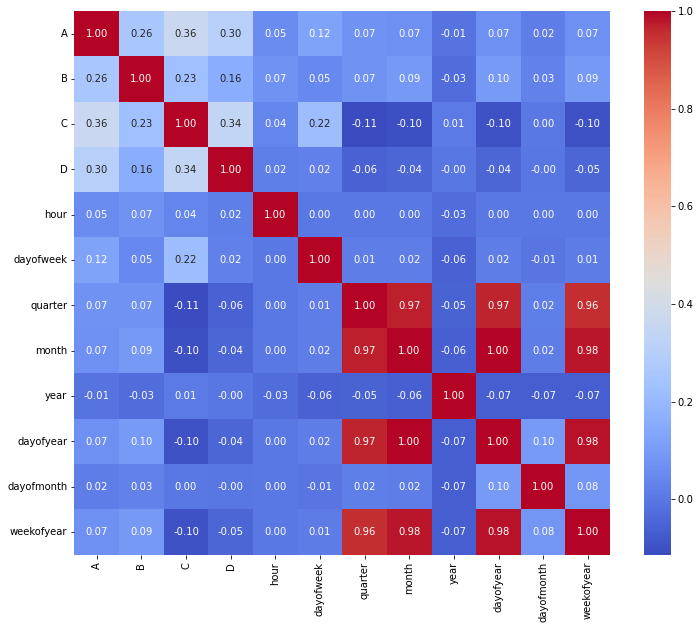

In [19]:
correlation_matrix = sector_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

Las variaciones más relevantes en el flujo de tráfico aéreo por cada uno de estos sectores se encuentra en el transcurso de las horas y de los días de la semana.

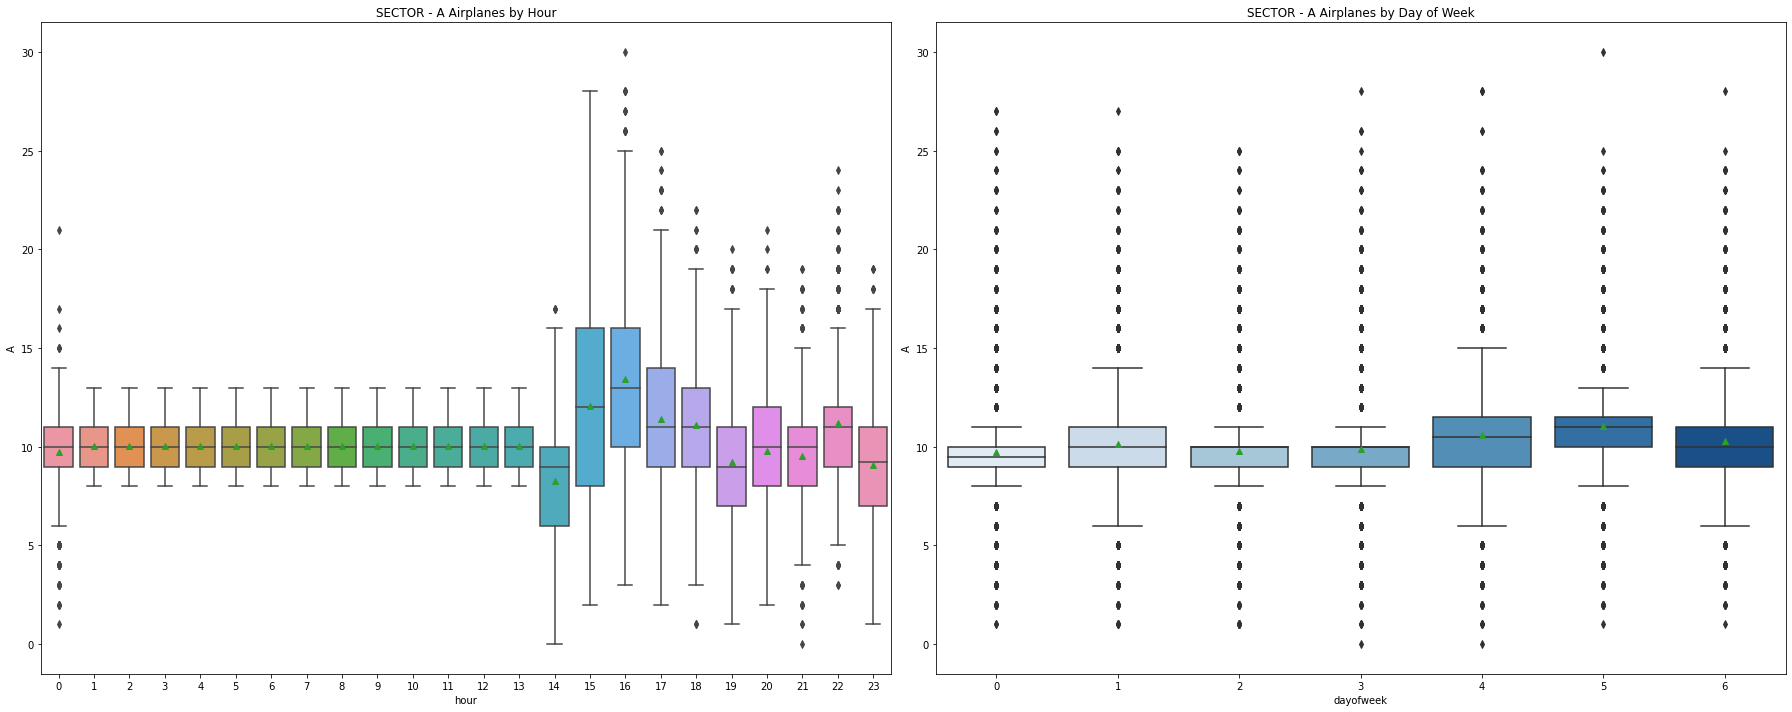

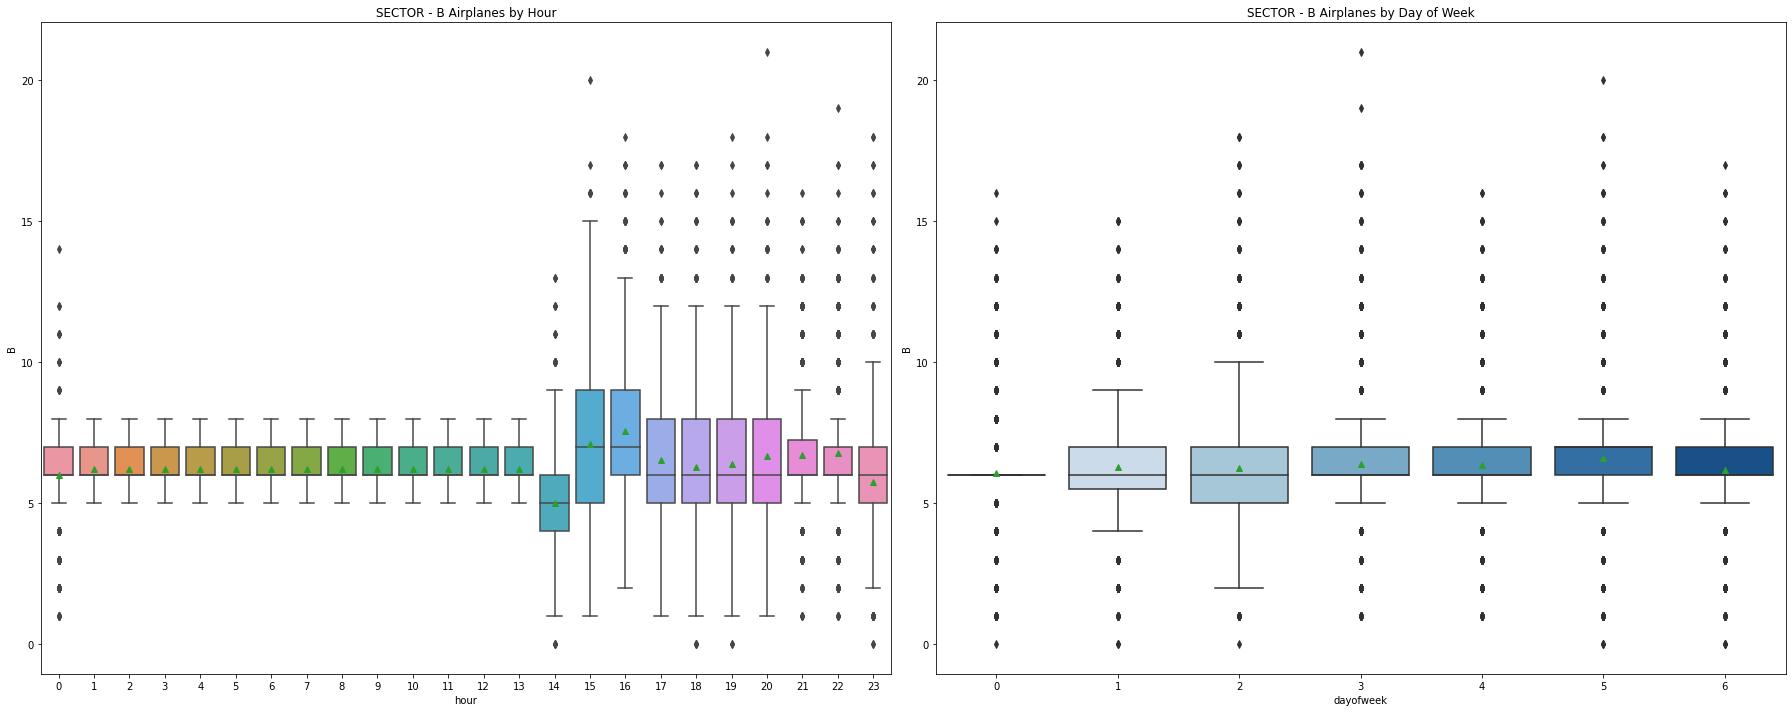

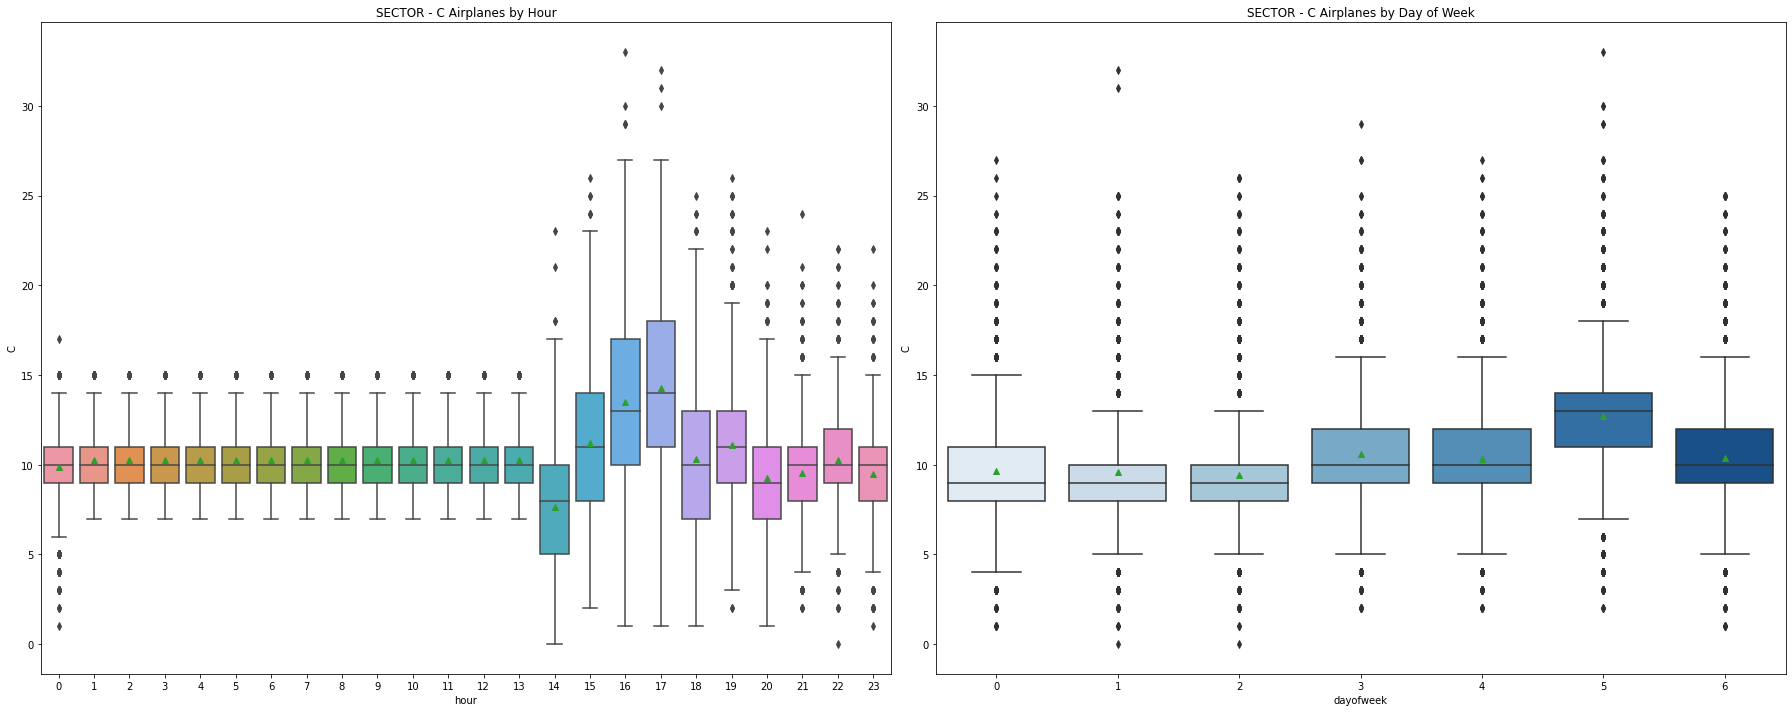

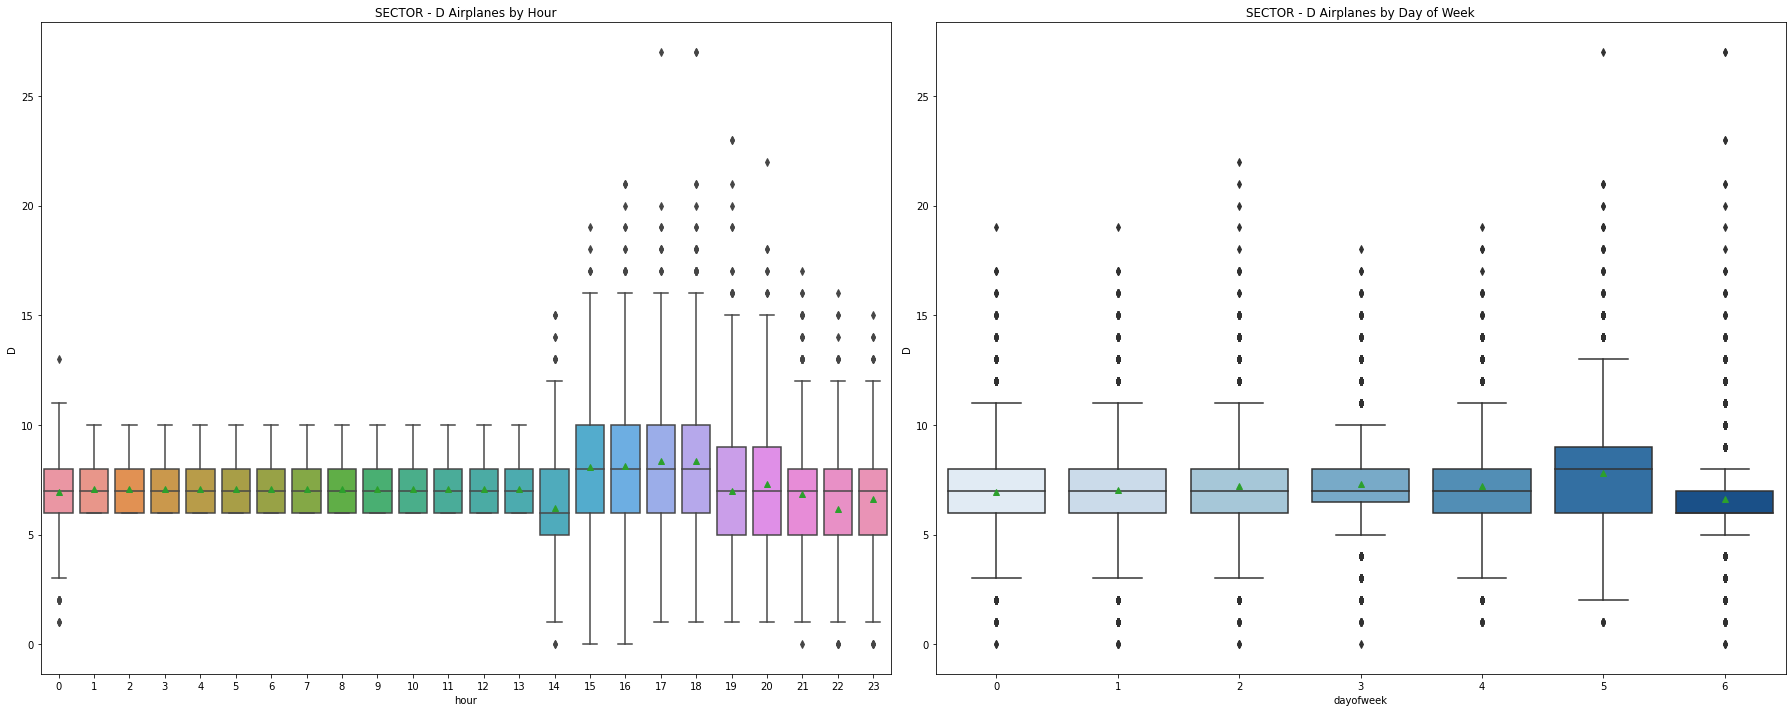

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sectors = ['A', 'B', 'C', 'D']

for sector in sectors:
    fig, (ax_hour, ax_dayofweek) = plt.subplots(1, 2, figsize=(25, 10))  # Create 1 row, 2 columns
    sns.boxplot(ax=ax_hour, data=sector_df, x='hour', y=sector, showmeans=True)
    sns.boxplot(ax=ax_dayofweek, data=sector_df, x='dayofweek', y=sector, palette='Blues', showmeans=True)

    # Set common titles for both subplots based on your data
    ax_hour.set_title(f'SECTOR - {sector} Airplanes by Hour')
    ax_dayofweek.set_title(f'SECTOR - {sector} Airplanes by Day of Week')

    # Adjust spacing between subplots for better readability
    plt.tight_layout()
    
    plt.show()


Sin embargo debe de ser analizado también el comportamiento en el transcurso del año de cada uno de los sectores. Se hace entonces la descomposición estacional de los datos para obtener, por cada sector aéreo, las componentes de tendencia, estacionalidad y los residuos

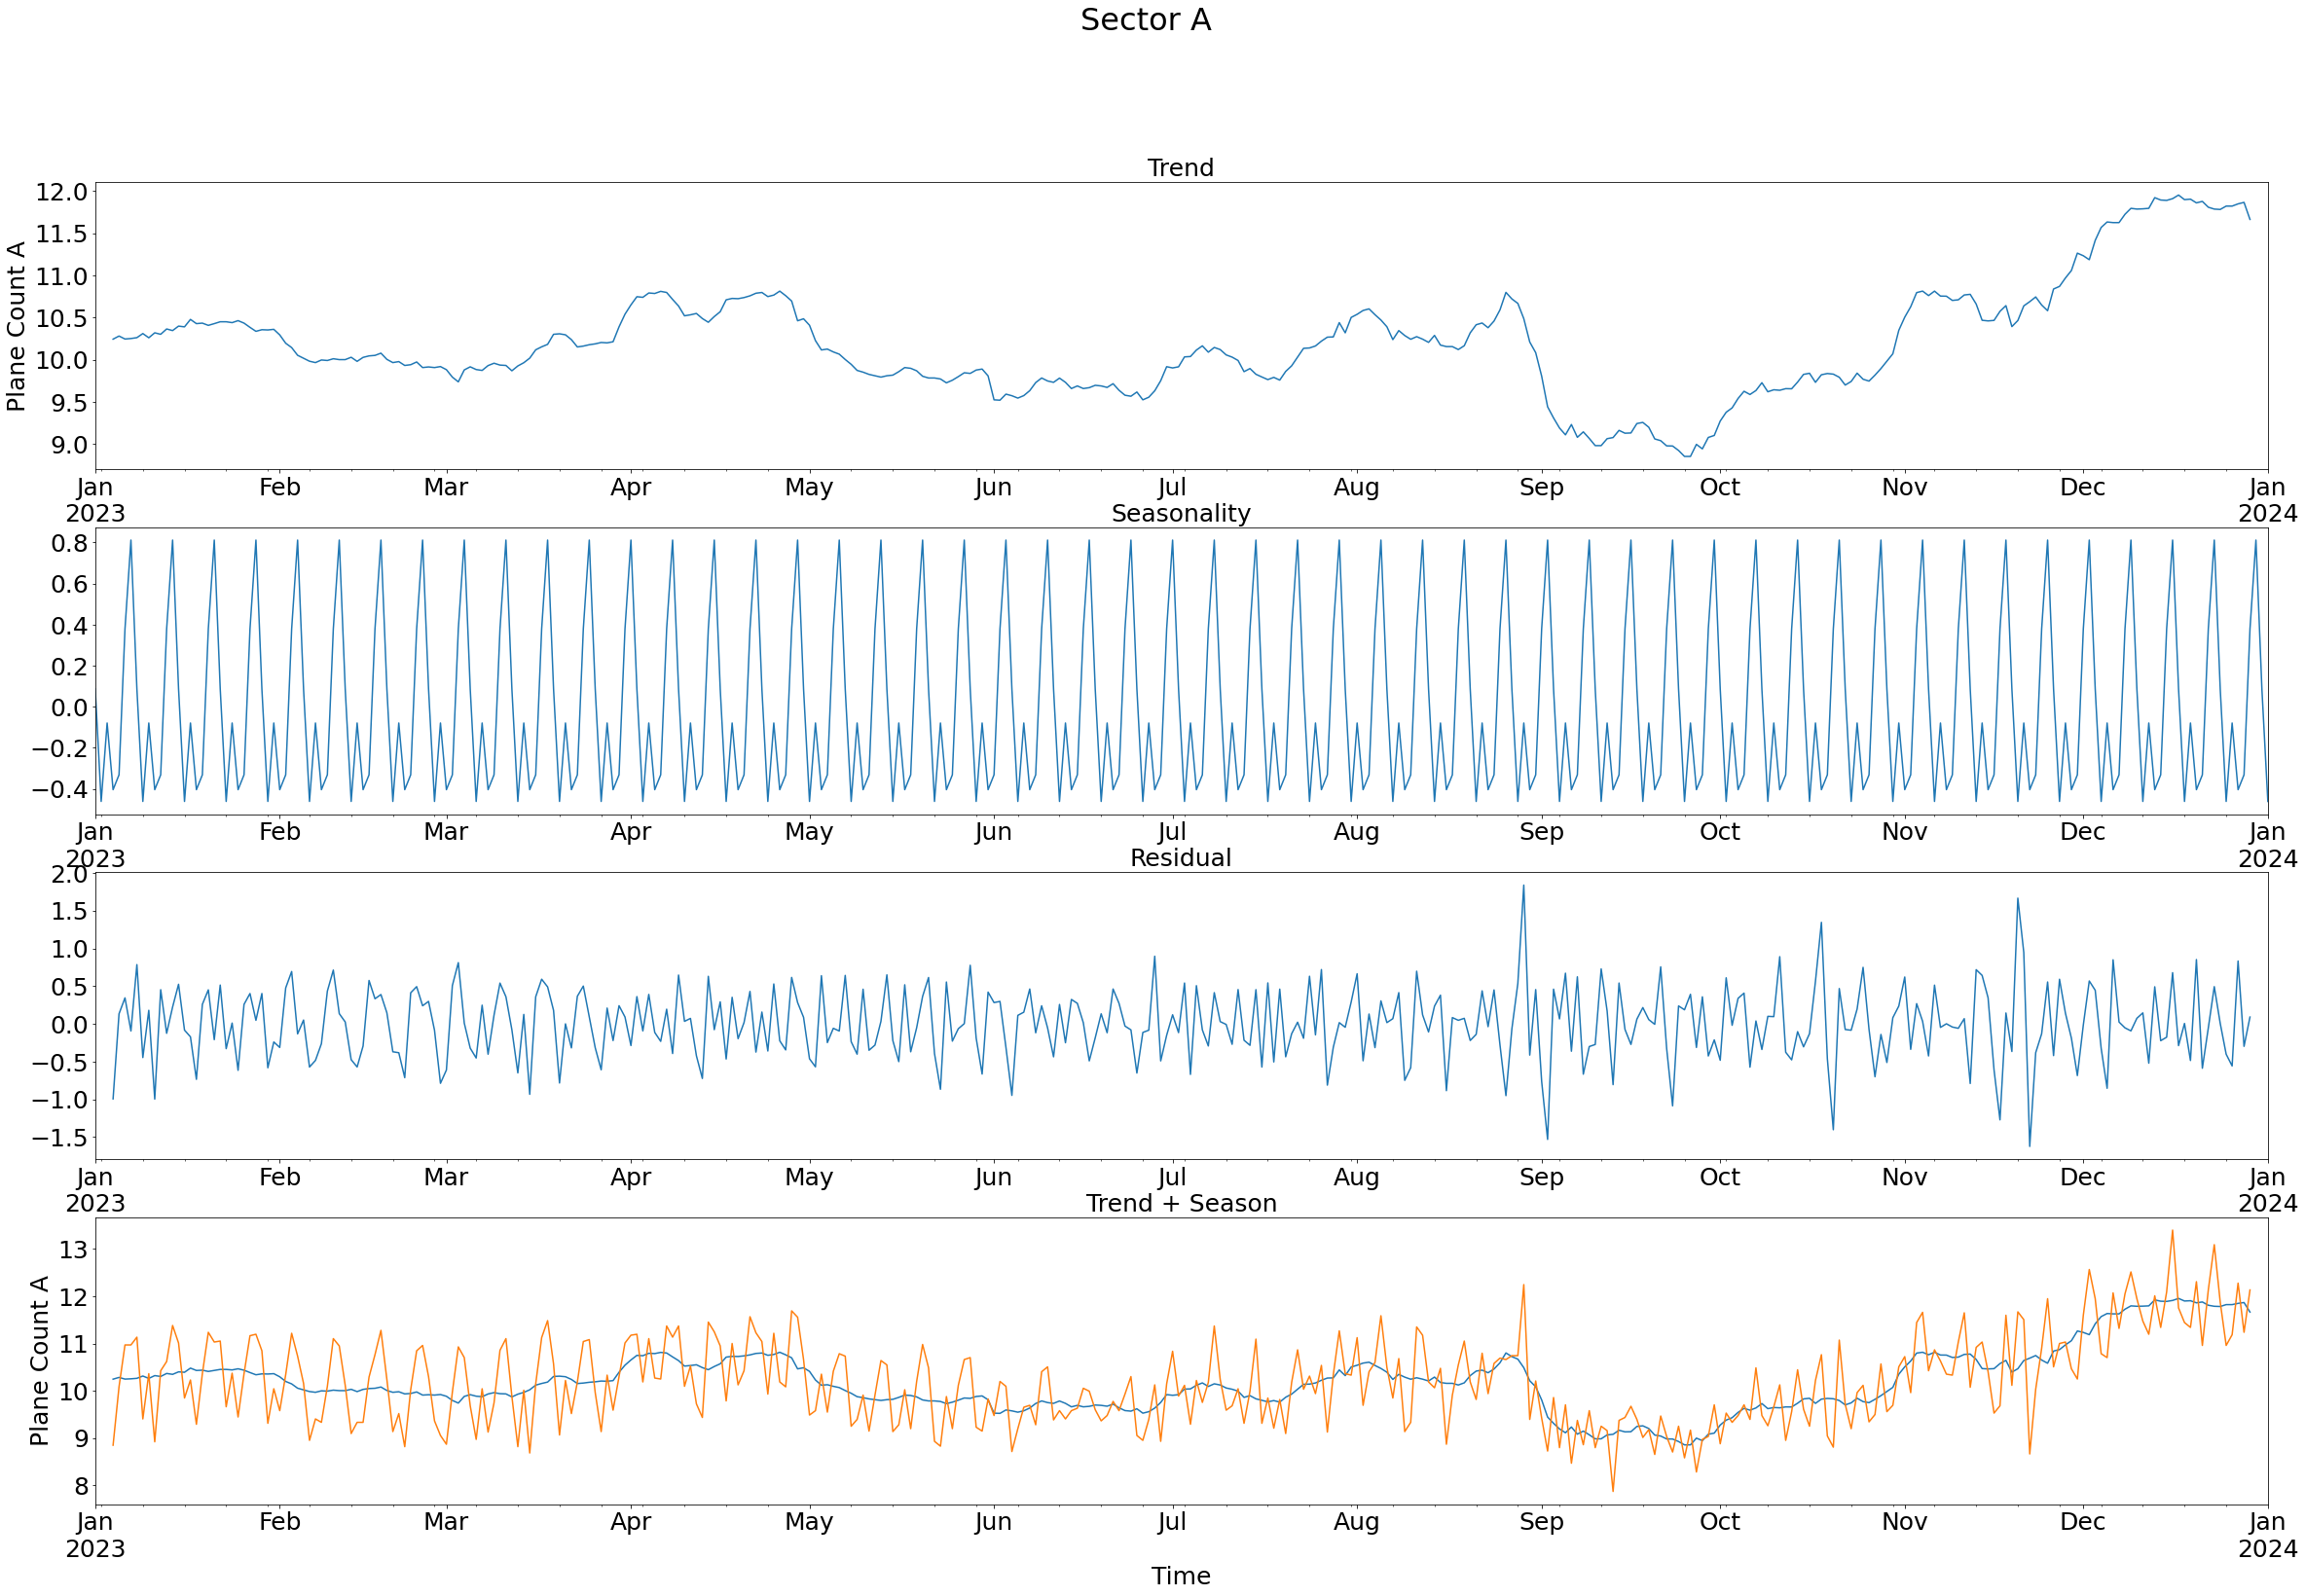

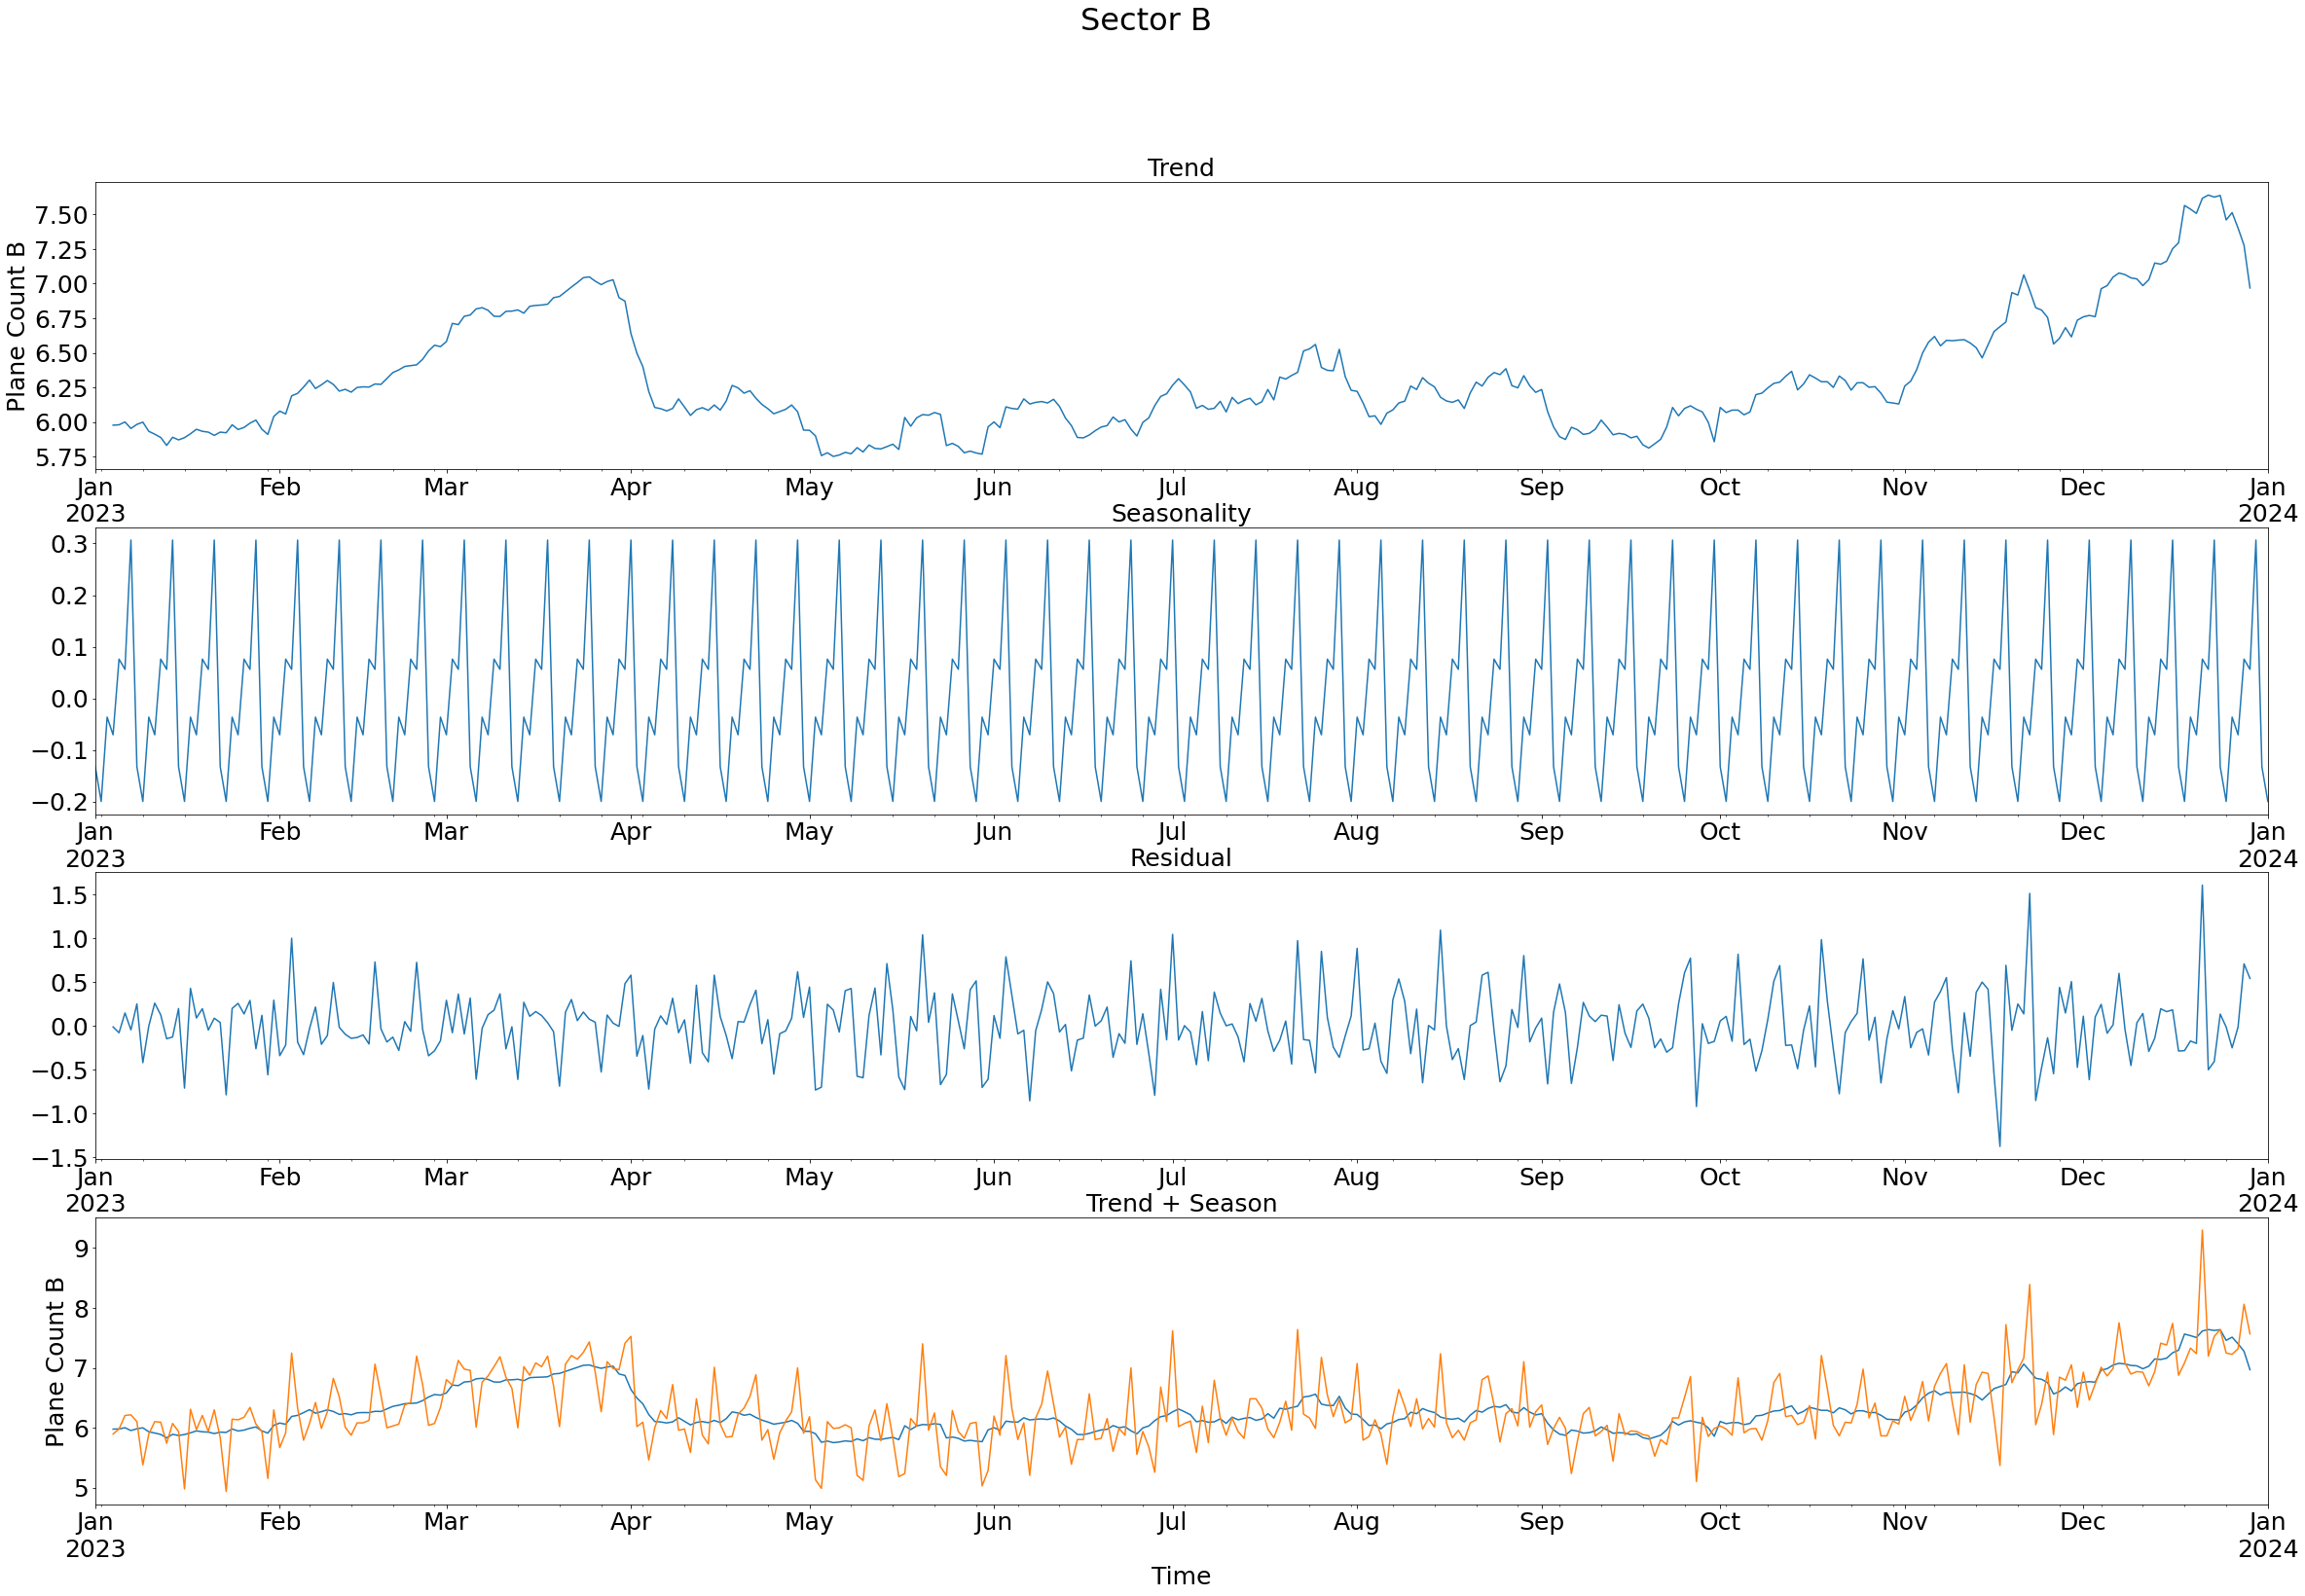

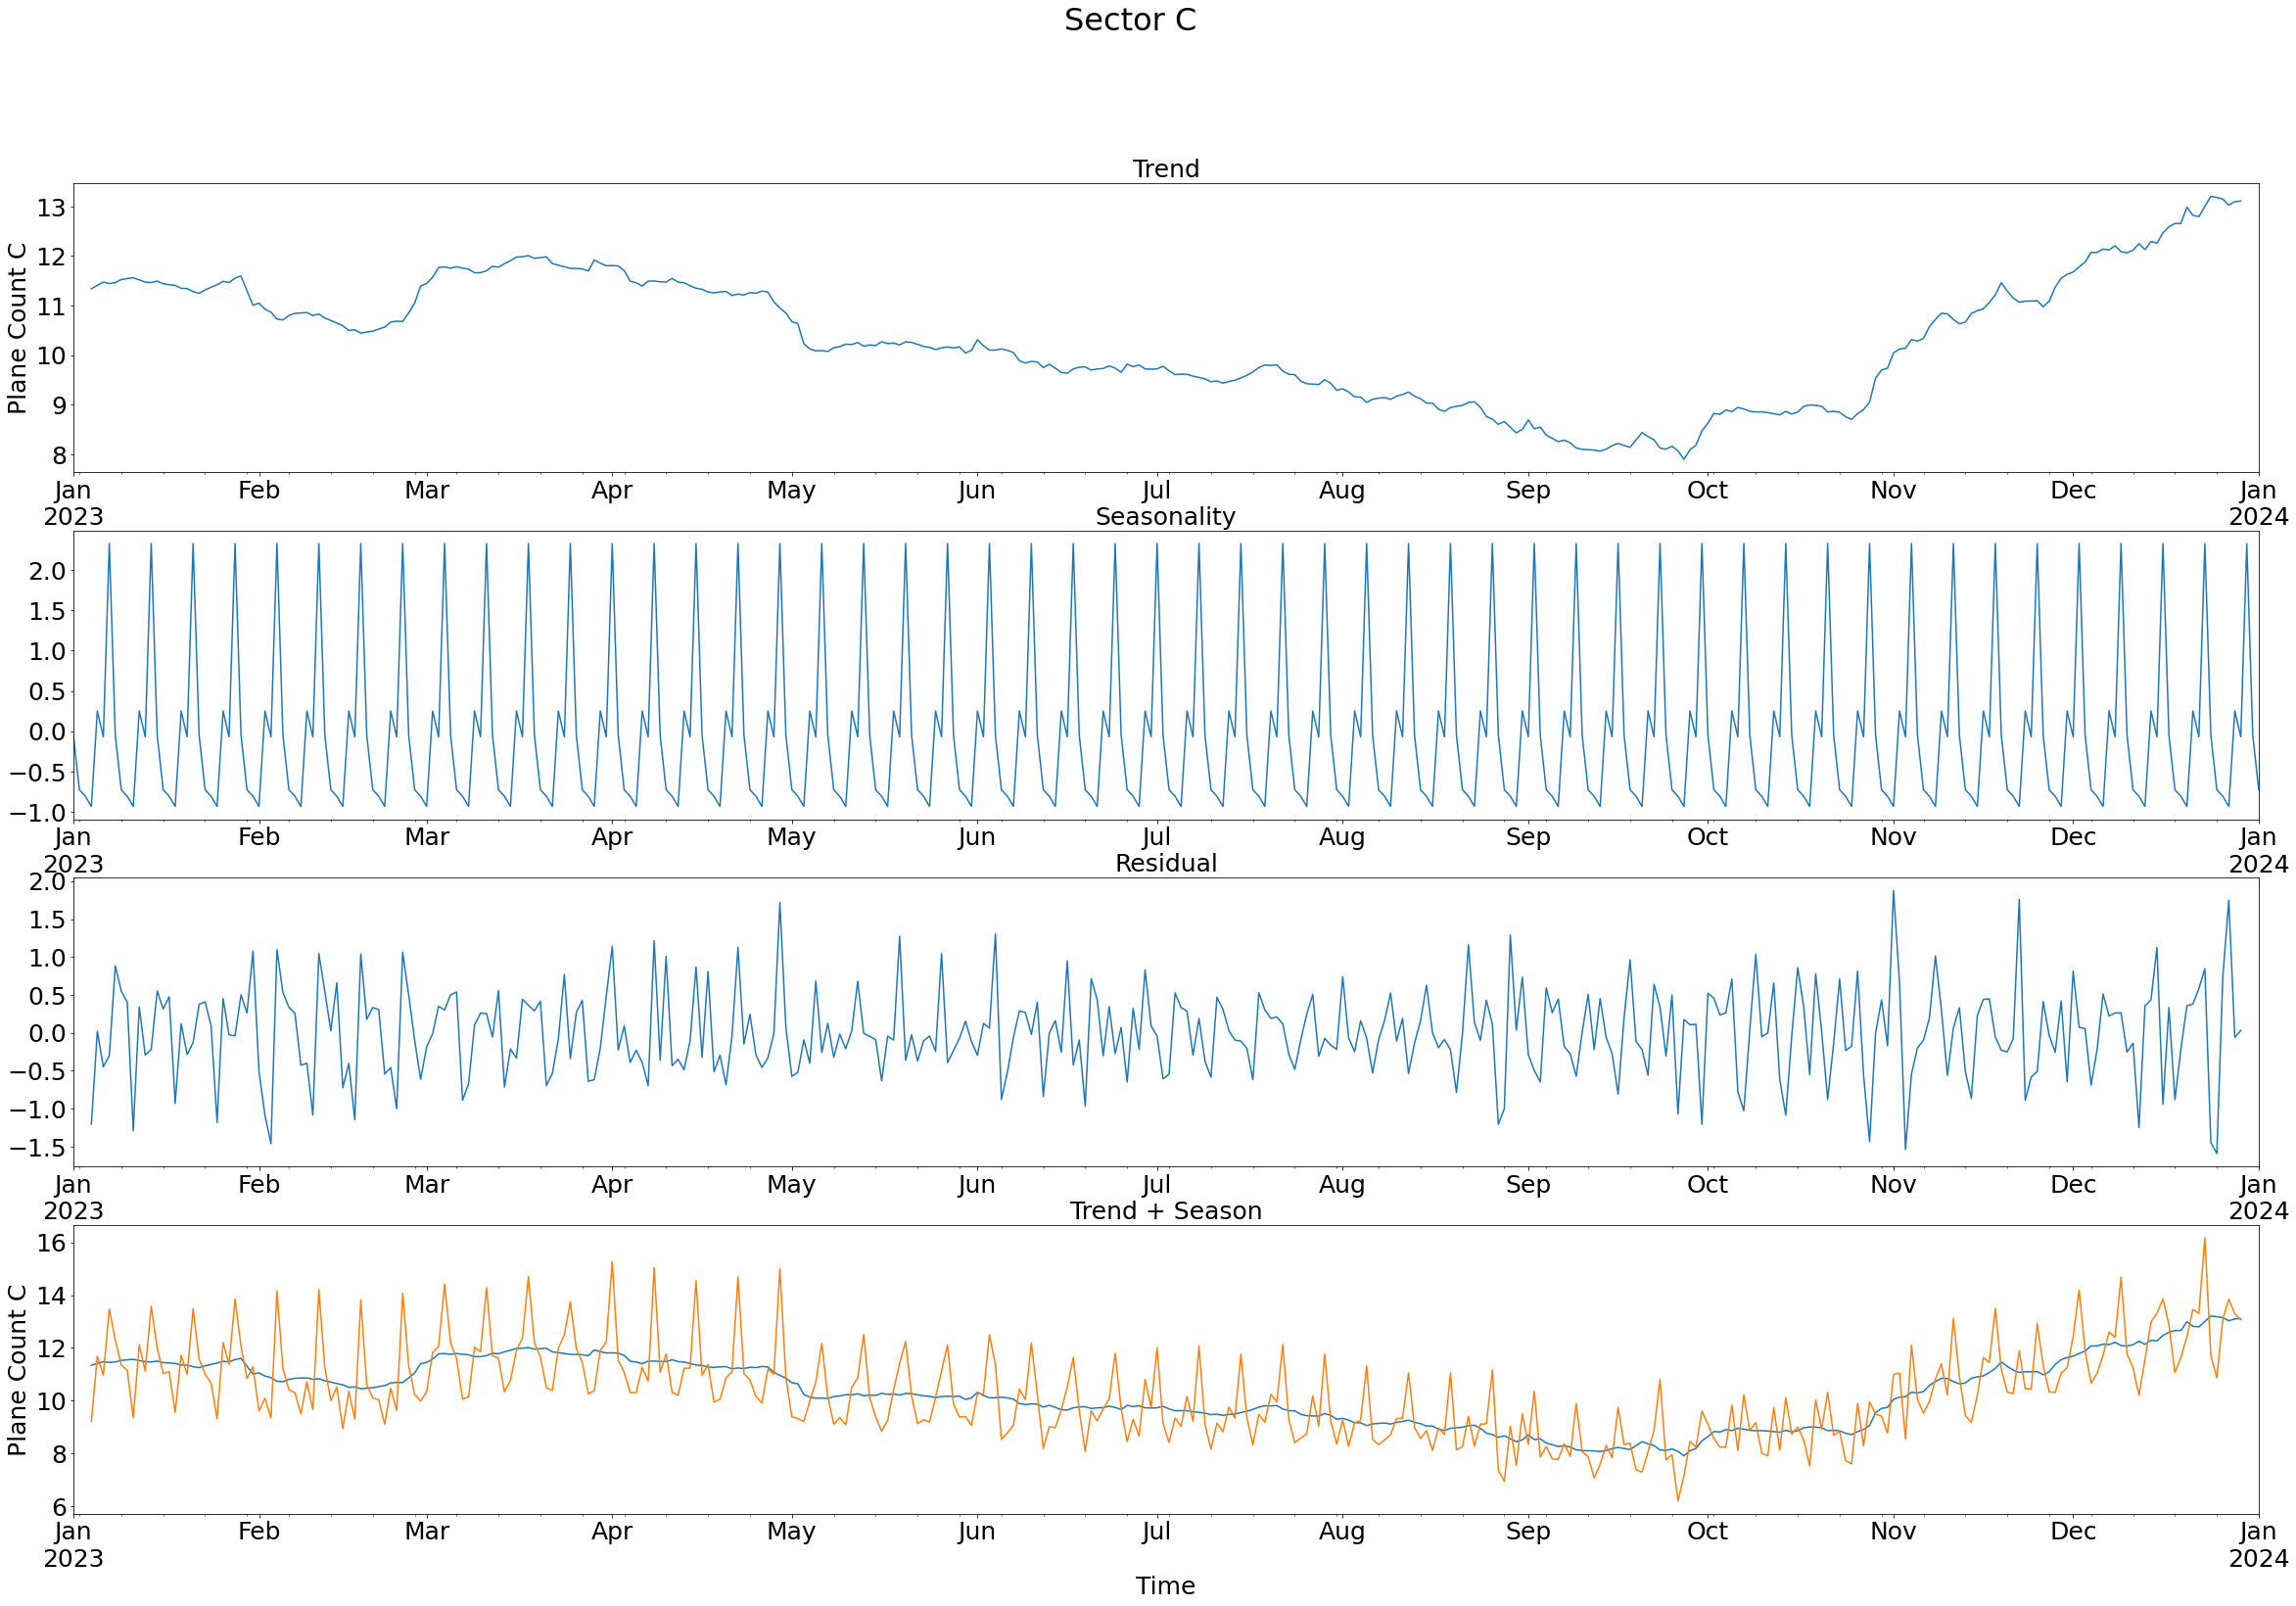

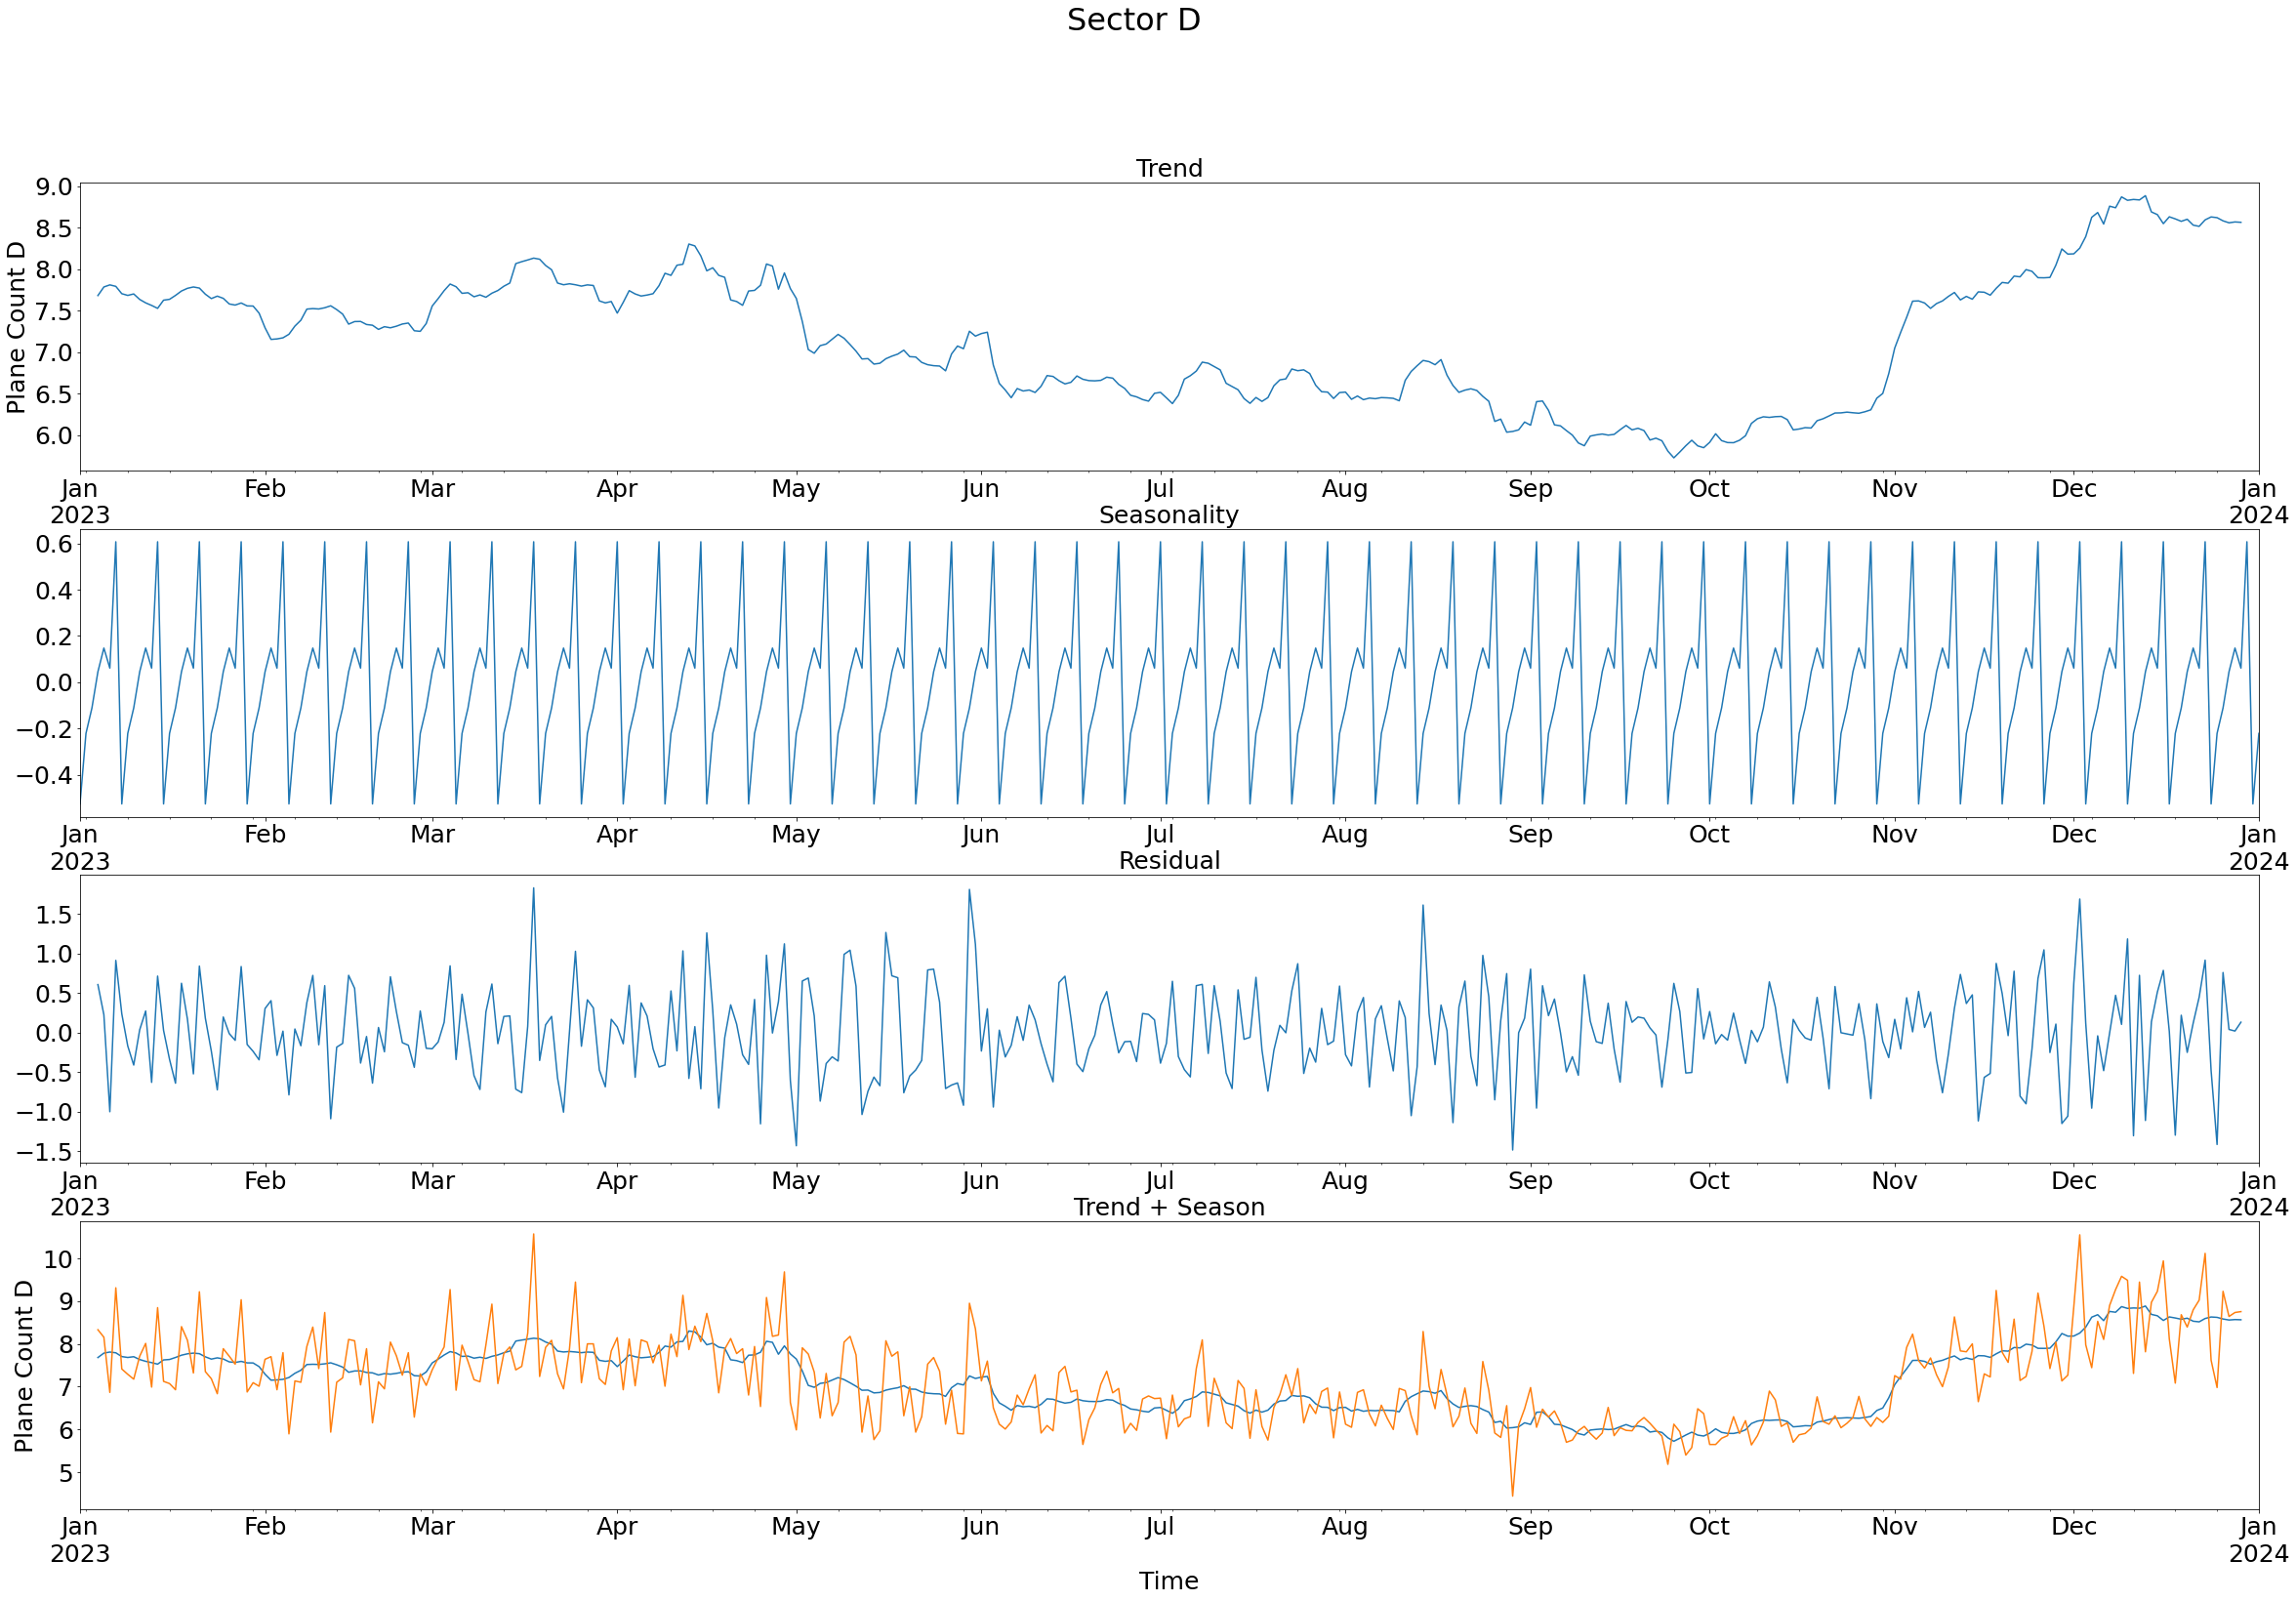

In [15]:
# plt.figure(figsize=(10, 6))
FONTSIZE = 25
for s in [*'ABCD']:
    fig, (ax_trend, ax_seasonality, ax_residual, ax_trend_season) = plt.subplots(4, 1, figsize=(40, 25))  # Create 1 row, 2 
    results = seasonal_decompose(sector_df[s].resample('D').mean())   
    
    trend = results.trend
    seasonal = results.seasonal
    residual = results.resid
    
    trend.plot(ax=ax_trend,fontsize=FONTSIZE)
    seasonal.plot(ax=ax_seasonality,fontsize=FONTSIZE)
    residual.plot(ax=ax_residual,fontsize=FONTSIZE)
    
    trend.plot(ax=ax_trend_season,fontsize=FONTSIZE)
    (seasonal + residual + trend).plot(ax=ax_trend_season)
    
    fig.suptitle(f"Sector {s}", fontsize=32)
    ax_trend.set_title(f"Trend", fontsize=FONTSIZE)
    ax_trend.set_xlabel(f"Time", fontsize=FONTSIZE)
    ax_trend.set_ylabel(f"Plane Count {s}", fontsize=FONTSIZE)

    ax_residual.set_title(f"Residual", fontsize=FONTSIZE)
    ax_residual.set_xlabel(f"Time", fontsize=FONTSIZE)
    # ax_residual.set_ylabel(f"Plane Count {s}", fontsize=FONTSIZE)
    
    ax_trend_season.set_title(f"Trend + Season", fontsize=FONTSIZE)
    ax_trend_season.set_xlabel(f"Time", fontsize=FONTSIZE)
    ax_trend_season.set_ylabel(f"Plane Count {s}", fontsize=FONTSIZE)

    ax_seasonality.set_title(f"Seasonality", fontsize=FONTSIZE)
    ax_seasonality.set_xlabel(f"Time", fontsize=FONTSIZE)
    plt.show()

Aislando en tres días representativos del año se puede observar la variación del flujo de tráfico aéreo en el transcurso del día

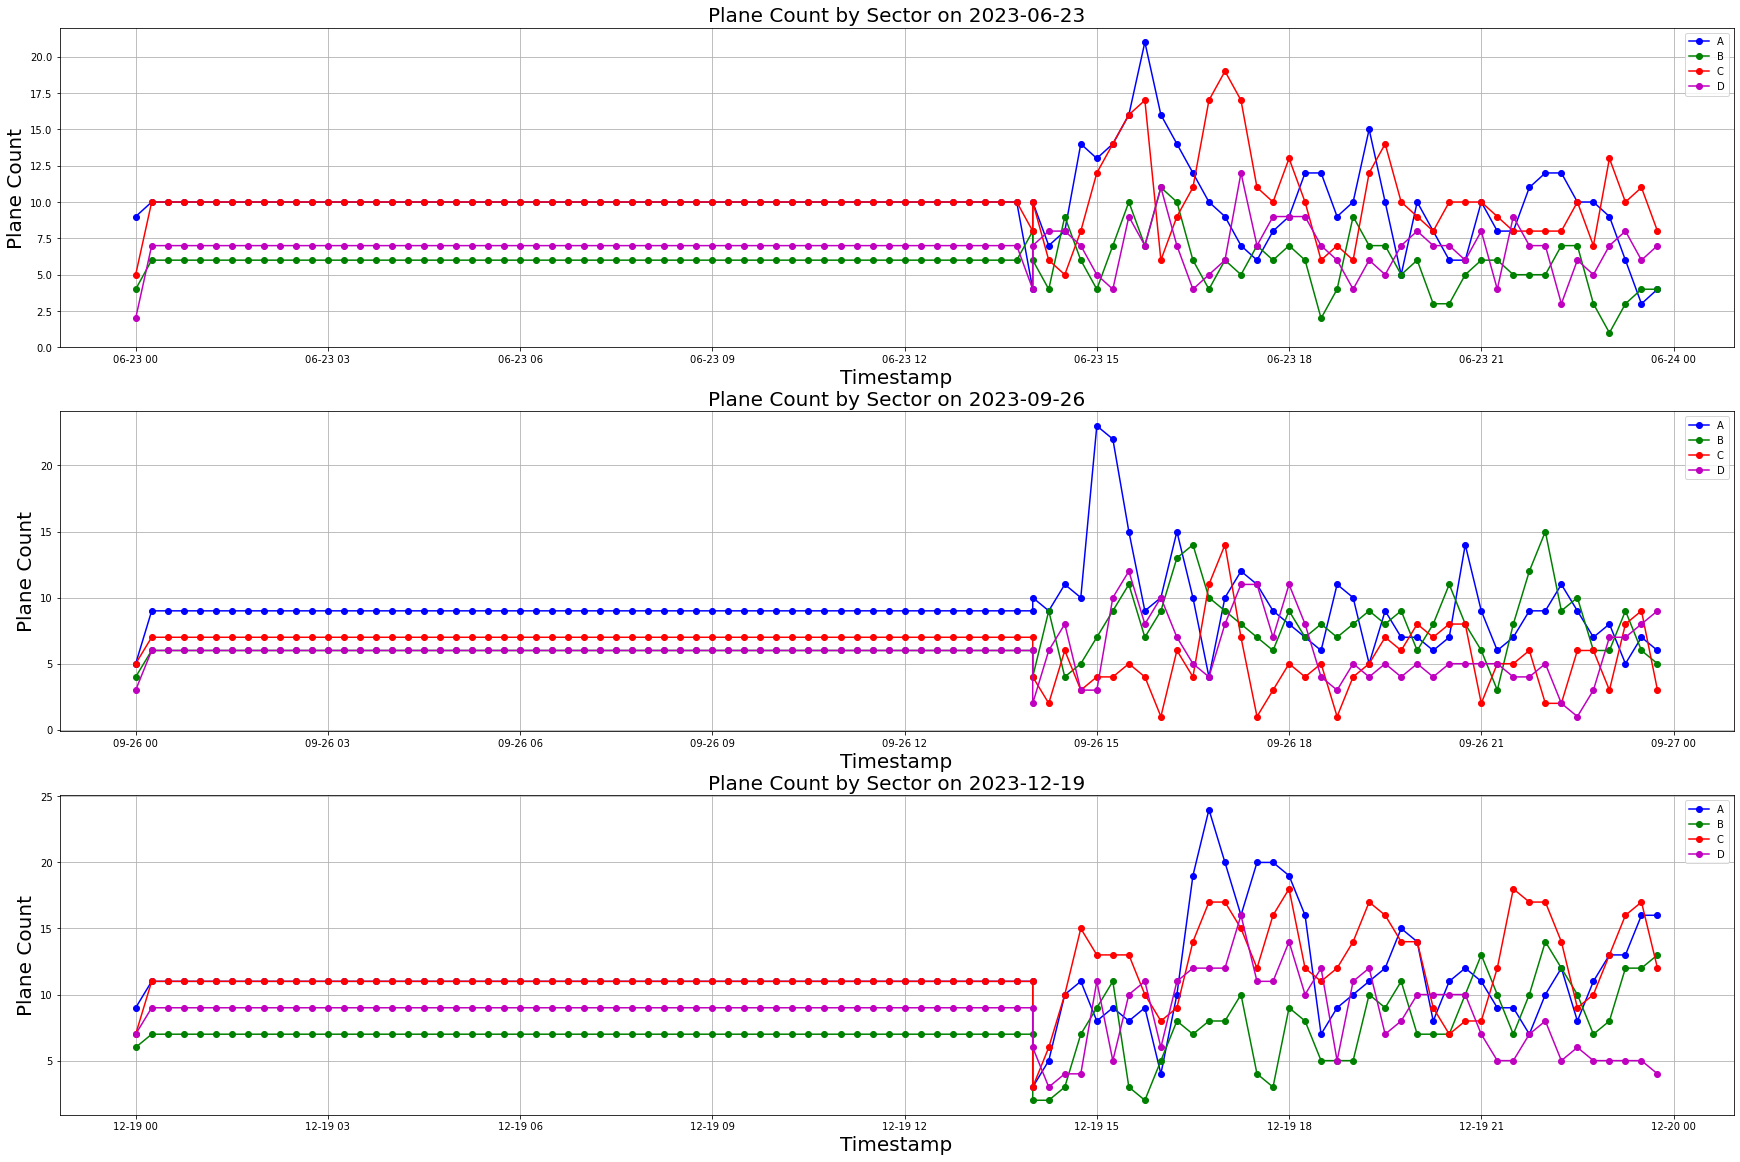

In [23]:
colors = ['b', 'g', 'r', 'm']
dates = ['2023-06-23', '2023-09-26', '2023-12-19']
fig, axes = plt.subplots(3,1,figsize=(30,20)) 

for day, ax in zip(dates, axes):
    data = sector_df.loc[day]
    
    for col, color in zip(data.columns, colors):
      ax.plot(data.index, data[col], label=col, color=color, marker='o')
    
#     # Set labels and title
    ax.set_xlabel('Timestamp', fontsize = FONTSIZE-5)
    ax.set_ylabel('Plane Count', fontsize = FONTSIZE-5)
    ax.set_title(f'Plane Count by Sector on {day}', fontsize = FONTSIZE-5)
    ax.legend()
    ax.grid(True)
    
plt.show()

Haciendo enfoque en las horas con datos reales se observa el comportamiento de la siguiente gráfica

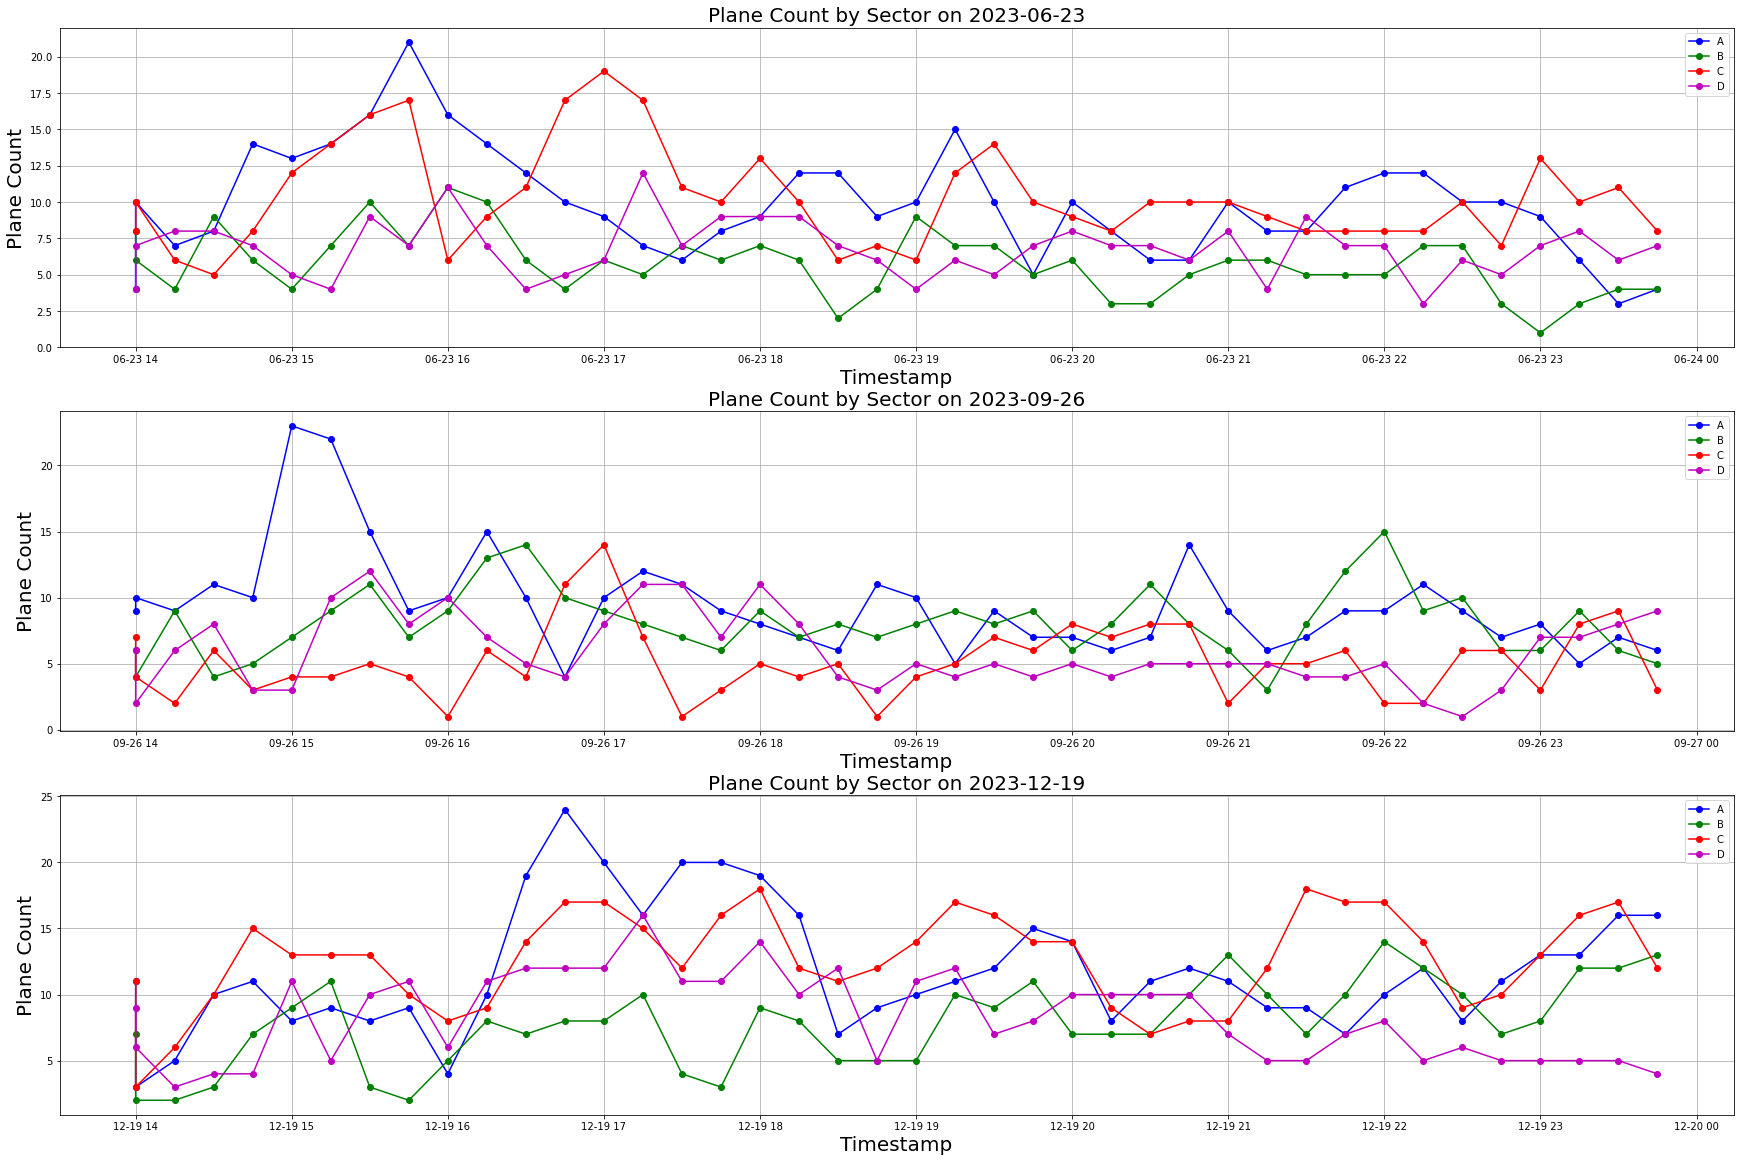

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

colors = ['b', 'g', 'r', 'm']
dates = ['2023-06-23', '2023-09-26', '2023-12-19']
fig, axes = plt.subplots(3,1,figsize=(30,20)) 

for day, ax in zip(dates, axes):
    data = sector_df.loc[day].between_time('14:00', '23:59')
    
    for col, color in zip(data.columns, colors):
      ax.plot(data.index, data[col], label=col, color=color, marker='o')
    
    ax.set_xlabel('Timestamp', fontsize = FONTSIZE-5)
    ax.set_ylabel('Plane Count', fontsize = FONTSIZE-5)
    ax.set_title(f'Plane Count by Sector on {day}', fontsize = FONTSIZE-5)
    ax.legend()
    ax.grid(True)
    
plt.show()

In [18]:
DB_FOLDER = 'DB'
DB_FILE_PATH = os.path.join(DB_FOLDER, 'sector_data.csv')

if os.path.exists(DB_FOLDER):
    rmtree(DB_FOLDER)
os.mkdir(DB_FOLDER)

sector_df.to_csv(DB_FILE_PATH)